In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [11]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [17]:
df = pd.read_csv('data/raw/OnlineRetail.csv', encoding='ISO-8859-1')

# Apply the same cleaning steps
df_clean = df[df['CustomerID'].notna()].copy()
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

print("✅ Data loaded and cleaned")
print(f"Shape: {df_clean.shape}")

✅ Data loaded and cleaned
Shape: (406829, 9)


In [18]:
print("="*60)
print("DEFINING CHURN")
print("="*60)

# What's the last date in our dataset?
max_date = df_clean['InvoiceDate'].max()
print(f"\nLast transaction date: {max_date}")

# For this analysis, we'll use this as our "snapshot date"
snapshot_date = max_date + timedelta(days=1)
print(f"Analysis snapshot date: {snapshot_date}")

print("\n📊 CHURN DEFINITION:")
print("   A customer is considered 'churned' if they haven't")
print("   purchased in the last 90 days from the snapshot date.")
print("\n   Why 90 days?")
print("   - This is a retail business with gift items")
print("   - Customers may not buy every month")
print("   - 90 days = reasonable re-purchase window")

DEFINING CHURN

Last transaction date: 2011-12-09 12:50:00
Analysis snapshot date: 2011-12-10 12:50:00

📊 CHURN DEFINITION:
   A customer is considered 'churned' if they haven't
   purchased in the last 90 days from the snapshot date.

   Why 90 days?
   - This is a retail business with gift items
   - Customers may not buy every month
   - 90 days = reasonable re-purchase window


In [19]:
print("\n" + "="*60)
print("CALCULATING RFM METRICS")
print("="*60)

# Filter for actual purchases only (no returns)
sales_df = df_clean[df_clean['TotalPrice'] > 0].copy()

# Group by customer and calculate RFM
rfm = sales_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (number of orders)
    'TotalPrice': 'sum'  # Monetary (total spend)
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\n✅ RFM Calculated!")
print("\nRFM Explanation:")
print("   • RECENCY: Days since last purchase (lower = better)")
print("   • FREQUENCY: Number of orders (higher = better)")
print("   • MONETARY: Total spend (higher = better)")

print("\nFirst few customers:")
print(rfm.head(10))

print("\nRFM Statistics:")
print(rfm.describe())


CALCULATING RFM METRICS

✅ RFM Calculated!

RFM Explanation:
   • RECENCY: Days since last purchase (lower = better)
   • FREQUENCY: Number of orders (higher = better)
   • MONETARY: Total spend (higher = better)

First few customers:
   CustomerID  Recency  Frequency  Monetary
0    12346.00      326          1  77183.60
1    12347.00        2          7   4310.00
2    12348.00       75          4   1797.24
3    12349.00       19          1   1757.55
4    12350.00      310          1    334.40
5    12352.00       36          8   2506.04
6    12353.00      204          1     89.00
7    12354.00      232          1   1079.40
8    12355.00      214          1    459.40
9    12356.00       23          3   2811.43

RFM Statistics:
       CustomerID  Recency  Frequency  Monetary
count     4338.00  4338.00    4338.00   4338.00
mean     15300.41    92.54       4.27   2054.27
std       1721.81   100.01       7.70   8989.23
min      12346.00     1.00       1.00      3.75
25%      13813.25    18

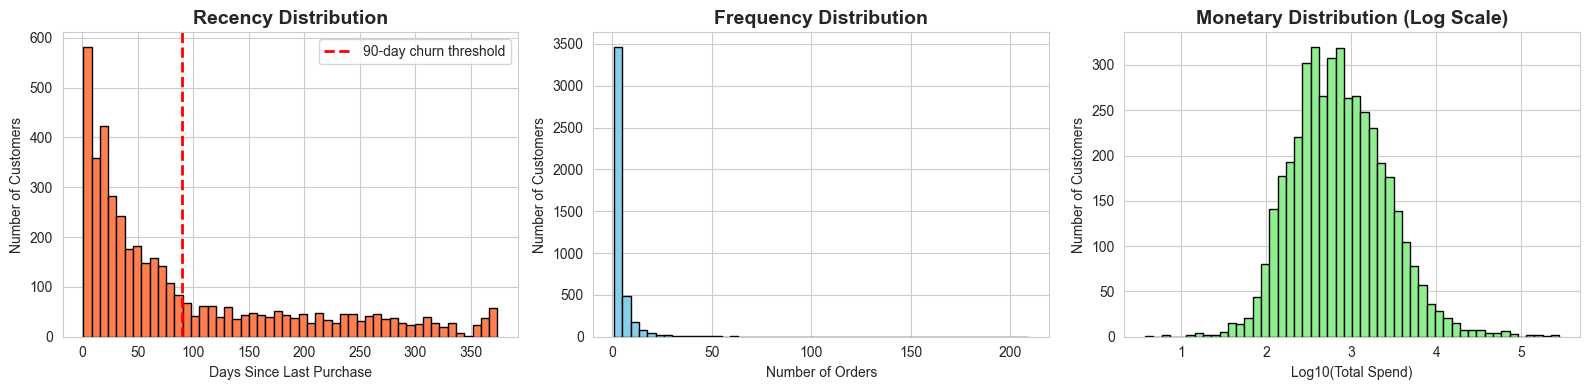

✅ Chart saved!


In [24]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Recency distribution
axes[0].hist(rfm['Recency'], bins=50, color='coral', edgecolor='black')
axes[0].set_title('Recency Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Number of Customers')
axes[0].axvline(90, color='red', linestyle='--', linewidth=2, label='90-day churn threshold')
axes[0].legend()

# Frequency distribution
axes[1].hist(rfm['Frequency'], bins=50, color='skyblue', edgecolor='black')
axes[1].set_title('Frequency Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Orders')
axes[1].set_ylabel('Number of Customers')

# Monetary distribution (log scale because of outliers)
axes[2].hist(np.log10(rfm['Monetary']), bins=50, color='lightgreen', edgecolor='black')
axes[2].set_title('Monetary Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Log10(Total Spend)')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('outputs/figures/rfm_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Chart saved!")

In [25]:
print("\n" + "="*60)
print("CREATING CHURN LABELS")
print("="*60)

# Define churn: customers who haven't purchased in 90+ days
rfm['Churned'] = (rfm['Recency'] > 90).astype(int)

churn_count = rfm['Churned'].sum()
churn_rate = (churn_count / len(rfm) * 100)

print(f"\n📊 CHURN ANALYSIS:")
print(f"   Total Customers: {len(rfm):,}")
print(f"   Churned Customers: {churn_count:,}")
print(f"   Active Customers: {len(rfm) - churn_count:,}")
print(f"   Churn Rate: {churn_rate:.1f}%")

# Show examples
print("\n✅ Sample of customers with churn labels:")
print(rfm.head(10))


CREATING CHURN LABELS

📊 CHURN ANALYSIS:
   Total Customers: 4,338
   Churned Customers: 1,449
   Active Customers: 2,889
   Churn Rate: 33.4%

✅ Sample of customers with churn labels:
   CustomerID  Recency  Frequency  Monetary  Churned
0    12346.00      326          1  77183.60        1
1    12347.00        2          7   4310.00        0
2    12348.00       75          4   1797.24        0
3    12349.00       19          1   1757.55        0
4    12350.00      310          1    334.40        1
5    12352.00       36          8   2506.04        0
6    12353.00      204          1     89.00        1
7    12354.00      232          1   1079.40        1
8    12355.00      214          1    459.40        1
9    12356.00       23          3   2811.43        0


In [26]:
print("\n" + "="*60)
print("ENGINEERING ADDITIONAL FEATURES")
print("="*60)

# Calculate average order value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Calculate days between purchases (customer lifetime / frequency)
# First, get first purchase date for each customer
first_purchase = sales_df.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'FirstPurchaseDate']

rfm = rfm.merge(first_purchase, on='CustomerID', how='left')
rfm['CustomerLifetimeDays'] = (snapshot_date - rfm['FirstPurchaseDate']).dt.days
rfm['AvgDaysBetweenPurchases'] = rfm['CustomerLifetimeDays'] / rfm['Frequency']

# Is this a one-time buyer?
rfm['IsOneTimeBuyer'] = (rfm['Frequency'] == 1).astype(int)

print("✅ New features created:")
print("   • AvgOrderValue: Average spend per order")
print("   • CustomerLifetimeDays: How long they've been a customer")
print("   • AvgDaysBetweenPurchases: Purchase frequency pattern")
print("   • IsOneTimeBuyer: Binary flag for single purchase")

print("\nEnriched dataset preview:")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 
           'AvgOrderValue', 'AvgDaysBetweenPurchases', 'Churned']].head())


ENGINEERING ADDITIONAL FEATURES
✅ New features created:
   • AvgOrderValue: Average spend per order
   • CustomerLifetimeDays: How long they've been a customer
   • AvgDaysBetweenPurchases: Purchase frequency pattern
   • IsOneTimeBuyer: Binary flag for single purchase

Enriched dataset preview:
   CustomerID  Recency  Frequency  Monetary  AvgOrderValue  \
0    12346.00      326          1  77183.60       77183.60   
1    12347.00        2          7   4310.00         615.71   
2    12348.00       75          4   1797.24         449.31   
3    12349.00       19          1   1757.55        1757.55   
4    12350.00      310          1    334.40         334.40   

   AvgDaysBetweenPurchases  Churned  
0                   326.00        1  
1                    52.43        0  
2                    89.50        0  
3                    19.00        0  
4                   310.00        1  


In [28]:
# Save for next phase
rfm.to_csv('data/processed/customer_rfm_features.csv', index=False)
print("\n✅ RFM dataset saved to: data/processed/customer_rfm_features.csv")
print(f"   Shape: {rfm.shape}")
print(f"   Features: {rfm.columns.tolist()}")


✅ RFM dataset saved to: data/processed/customer_rfm_features.csv
   Shape: (4338, 10)
   Features: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churned', 'AvgOrderValue', 'FirstPurchaseDate', 'CustomerLifetimeDays', 'AvgDaysBetweenPurchases', 'IsOneTimeBuyer']


In [29]:
print("="*60)
print("PHASE 3: CUSTOMER SEGMENTATION")
print("="*60)

# Load the processed RFM data
rfm = pd.read_csv('data/processed/customer_rfm_features.csv')

print(f"\n✅ Loaded {len(rfm)} customers with {rfm.shape[1]} features")
print(f"\nFeatures: {rfm.columns.tolist()}")

PHASE 3: CUSTOMER SEGMENTATION

✅ Loaded 4338 customers with 10 features

Features: ['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churned', 'AvgOrderValue', 'FirstPurchaseDate', 'CustomerLifetimeDays', 'AvgDaysBetweenPurchases', 'IsOneTimeBuyer']


In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("\n" + "="*60)
print("PREPARING DATA FOR CLUSTERING")
print("="*60)

# Select features for clustering (RFM only)
features_for_clustering = ['Recency', 'Frequency', 'Monetary']
X = rfm[features_for_clustering].copy()

print(f"\nClustering on: {features_for_clustering}")
print(f"Shape: {X.shape}")

# Standardize the features (very important for K-means!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n✅ Features scaled (mean=0, std=1)")
print("\n📊 Why scaling matters:")
print("   - Recency is in days (0-374)")
print("   - Frequency is in orders (1-209)")
print("   - Monetary is in pounds (£3-£280k)")
print("   - Without scaling, Monetary would dominate the clustering!")


PREPARING DATA FOR CLUSTERING

Clustering on: ['Recency', 'Frequency', 'Monetary']
Shape: (4338, 3)

✅ Features scaled (mean=0, std=1)

📊 Why scaling matters:
   - Recency is in days (0-374)
   - Frequency is in orders (1-209)
   - Monetary is in pounds (£3-£280k)
   - Without scaling, Monetary would dominate the clustering!



FINDING OPTIMAL NUMBER OF CLUSTERS


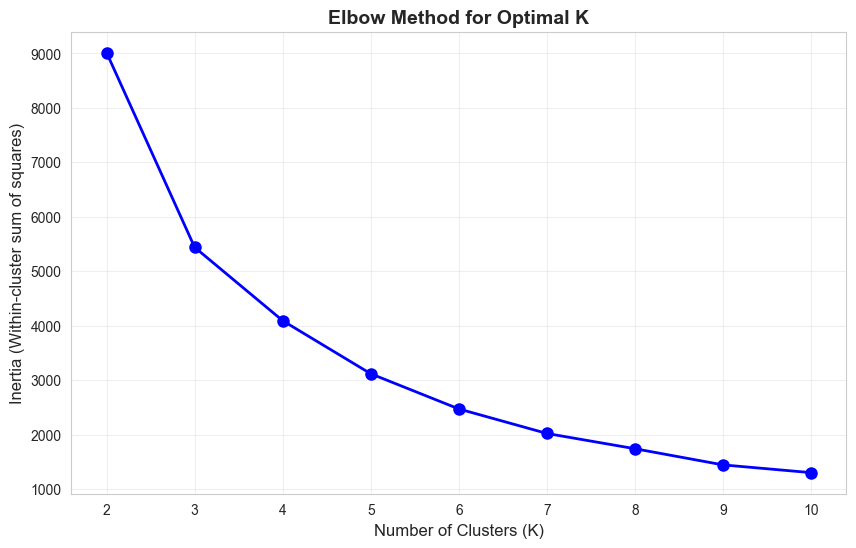


✅ Chart saved!

📊 How to interpret:
   - Look for the 'elbow' where the curve bends
   - This is where adding more clusters gives diminishing returns
   - Common sweet spot: 4-5 clusters for retail segmentation


In [31]:
print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Test different numbers of clusters
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.xticks(K_range)
plt.savefig('outputs/figures/elbow_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved!")
print("\n📊 How to interpret:")
print("   - Look for the 'elbow' where the curve bends")
print("   - This is where adding more clusters gives diminishing returns")
print("   - Common sweet spot: 4-5 clusters for retail segmentation")

In [32]:
print("\n" + "="*60)
print("CREATING CUSTOMER SEGMENTS")
print("="*60)

# Based on elbow curve, let's use 4 clusters
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Segment'] = kmeans.fit_predict(X_scaled)

print(f"\n✅ Created {optimal_k} customer segments")
print("\nSegment distribution:")
print(rfm['Segment'].value_counts().sort_index())


CREATING CUSTOMER SEGMENTS

✅ Created 4 customer segments

Segment distribution:
Segment
0    3054
1    1067
2      13
3     204
Name: count, dtype: int64


In [33]:
print("\n" + "="*60)
print("SEGMENT CHARACTERISTICS")
print("="*60)

# Calculate average RFM values for each segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Churned': 'mean',
    'CustomerID': 'count'
}).round(2)

segment_analysis.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 
                             'Churn_Rate', 'Customer_Count']

print("\n📊 Segment Profile:")
print(segment_analysis)

# Give segments meaningful names based on their characteristics
segment_names = {}
for seg in range(optimal_k):
    recency = segment_analysis.loc[seg, 'Avg_Recency']
    frequency = segment_analysis.loc[seg, 'Avg_Frequency']
    monetary = segment_analysis.loc[seg, 'Avg_Monetary']
    
    if recency < 50 and frequency > 5 and monetary > 2000:
        segment_names[seg] = "Champions"
    elif recency < 50 and frequency > 3:
        segment_names[seg] = "Loyal Customers"
    elif recency > 150:
        segment_names[seg] = "At Risk / Lost"
    elif frequency == 1 or frequency < 2:
        segment_names[seg] = "New/One-Time"
    else:
        segment_names[seg] = f"Segment {seg}"

# Map names to dataframe
rfm['Segment_Name'] = rfm['Segment'].map(segment_names)

print("\n✅ Segment Names Assigned:")
for seg, name in segment_names.items():
    count = len(rfm[rfm['Segment'] == seg])
    print(f"   Segment {seg}: {name} ({count} customers)")


SEGMENT CHARACTERISTICS

📊 Segment Profile:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Churn_Rate  Customer_Count
Segment                                                                      
0              43.70           3.68       1359.05        0.12            3054
1             248.08           1.55        480.62        1.00            1067
2               7.38          82.54     127338.31        0.00              13
3              15.50          22.33      12709.09        0.02             204

✅ Segment Names Assigned:
   Segment 0: Loyal Customers (3054 customers)
   Segment 1: At Risk / Lost (1067 customers)
   Segment 2: Champions (13 customers)
   Segment 3: Champions (204 customers)


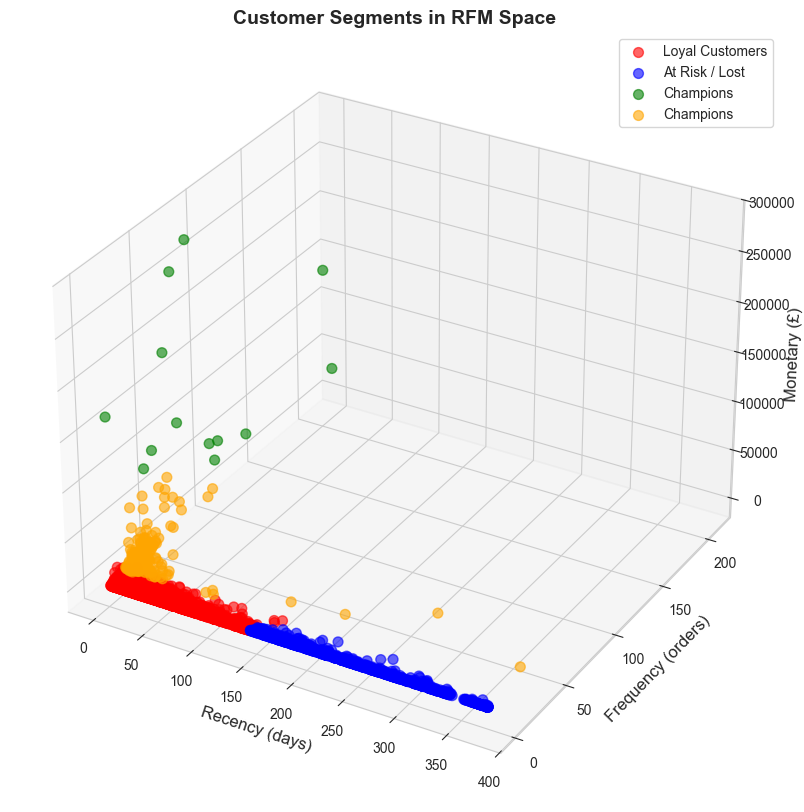

✅ 3D visualization saved!


In [34]:
# Create 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'blue', 'green', 'orange', 'purple']

for seg in range(optimal_k):
    seg_data = rfm[rfm['Segment'] == seg]
    ax.scatter(seg_data['Recency'], 
               seg_data['Frequency'], 
               seg_data['Monetary'],
               c=colors[seg], 
               label=segment_names[seg],
               alpha=0.6,
               s=50)

ax.set_xlabel('Recency (days)', fontsize=12)
ax.set_ylabel('Frequency (orders)', fontsize=12)
ax.set_zlabel('Monetary (£)', fontsize=12)
ax.set_title('Customer Segments in RFM Space', fontsize=14, fontweight='bold')
ax.legend()

plt.savefig('outputs/figures/segment_3d_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 3D visualization saved!")

In [35]:
# Save the segmented customer data
rfm.to_csv('data/processed/customer_segments.csv', index=False)
print("\n✅ Segmented data saved to: data/processed/customer_segments.csv")


✅ Segmented data saved to: data/processed/customer_segments.csv


In [36]:
print("="*60)
print("PHASE 4: CHURN PREDICTION MODEL")
print("="*60)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Load segmented data
rfm = pd.read_csv('data/processed/customer_segments.csv')

print(f"\n✅ Loaded {len(rfm)} customers")
print(f"Target variable: Churned (0=Active, 1=Churned)")
print(f"\nClass distribution:")
print(rfm['Churned'].value_counts())
print(f"Churn rate: {rfm['Churned'].mean()*100:.1f}%")

PHASE 4: CHURN PREDICTION MODEL

✅ Loaded 4338 customers
Target variable: Churned (0=Active, 1=Churned)

Class distribution:
Churned
0    2889
1    1449
Name: count, dtype: int64
Churn rate: 33.4%


In [37]:
print("\n" + "="*60)
print("PREPARING FEATURES FOR MODELING")
print("="*60)

# Select features (exclude target, IDs, and dates)
feature_columns = ['Recency', 'Frequency', 'Monetary', 
                   'AvgOrderValue', 'AvgDaysBetweenPurchases', 
                   'IsOneTimeBuyer']

X = rfm[feature_columns].copy()
y = rfm['Churned'].copy()

print(f"\nFeatures for prediction: {feature_columns}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Handle any infinite or missing values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n✅ Features prepared and scaled")


PREPARING FEATURES FOR MODELING

Features for prediction: ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'AvgDaysBetweenPurchases', 'IsOneTimeBuyer']
X shape: (4338, 6)
y shape: (4338,)

✅ Features prepared and scaled


In [38]:
print("\n" + "="*60)
print("SPLITTING DATA")
print("="*60)

# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} customers")
print(f"Test set: {X_test.shape[0]} customers")
print(f"\nTrain churn rate: {y_train.mean()*100:.1f}%")
print(f"Test churn rate: {y_test.mean()*100:.1f}%")



SPLITTING DATA

Training set: 3470 customers
Test set: 868 customers

Train churn rate: 33.4%
Test churn rate: 33.4%


In [39]:
print("\n" + "="*60)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*60)

# Train model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 LOGISTIC REGRESSION RESULTS:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Active', 'Churned']))

# ROC-AUC Score
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"\nROC-AUC Score: {roc_auc_lr:.3f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm_lr)


MODEL 1: LOGISTIC REGRESSION

📊 LOGISTIC REGRESSION RESULTS:

Classification Report:
              precision    recall  f1-score   support

      Active       0.99      1.00      0.99       578
     Churned       1.00      0.98      0.99       290

    accuracy                           0.99       868
   macro avg       0.99      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868


ROC-AUC Score: 1.000

Confusion Matrix:
[[578   0]
 [  7 283]]


In [40]:
print("\n" + "="*60)
print("MODEL 2: RANDOM FOREST")
print("="*60)

# Train model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate
print("\n📊 RANDOM FOREST RESULTS:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Active', 'Churned']))

# ROC-AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"\nROC-AUC Score: {roc_auc_rf:.3f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm_rf)


MODEL 2: RANDOM FOREST

📊 RANDOM FOREST RESULTS:

Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       578
     Churned       1.00      1.00      1.00       290

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868


ROC-AUC Score: 1.000

Confusion Matrix:
[[578   0]
 [  0 290]]



FEATURE IMPORTANCE ANALYSIS

📊 Most Important Features for Predicting Churn:
                   Feature  Importance
0                  Recency        0.72
4  AvgDaysBetweenPurchases        0.21
1                Frequency        0.03
2                 Monetary        0.02
5           IsOneTimeBuyer        0.02
3            AvgOrderValue        0.00


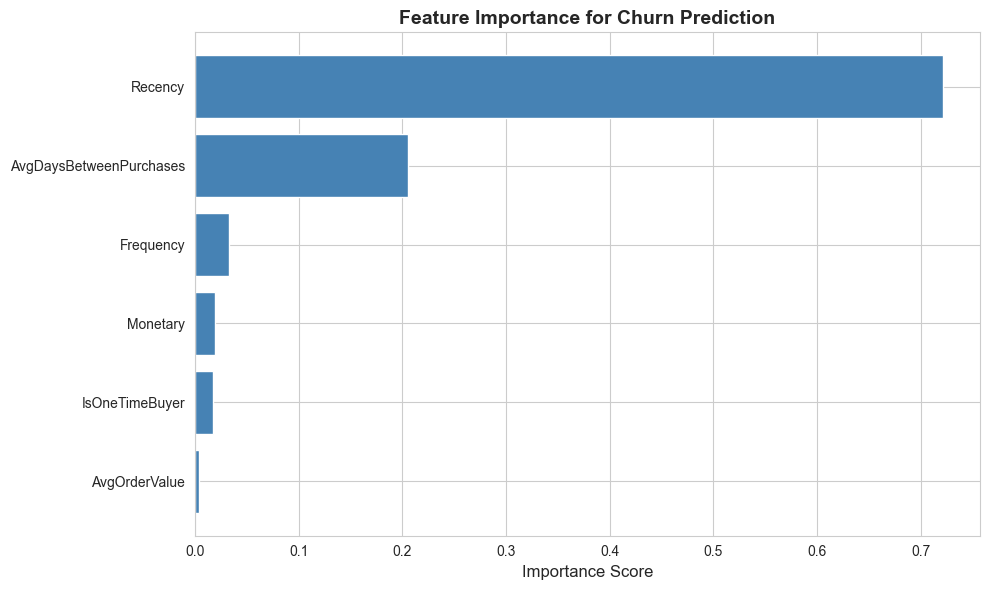


✅ Chart saved!


In [41]:
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Most Important Features for Predicting Churn:")
print(feature_importance)

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance for Churn Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('outputs/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved!")

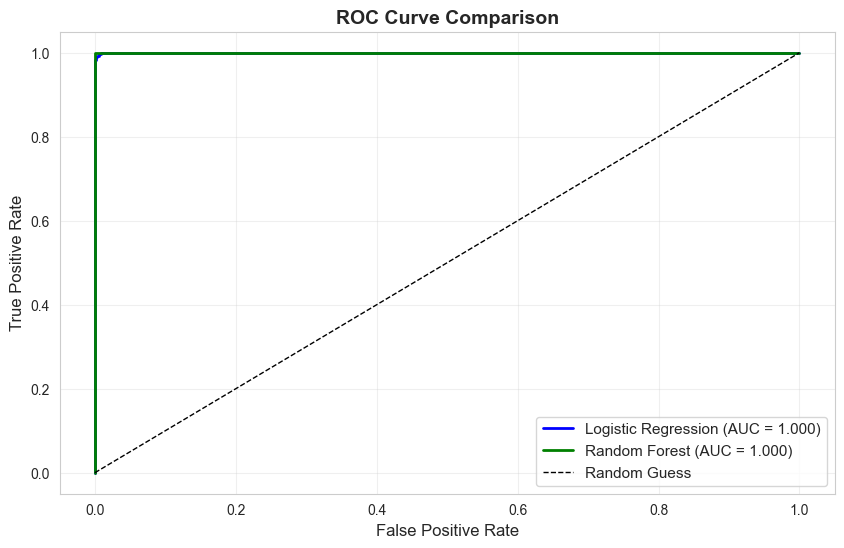

✅ ROC curve saved!


In [42]:
# Plot ROC curves for both models
plt.figure(figsize=(10, 6))

# Logistic Regression ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.3f})', 
         linewidth=2, color='blue')

# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})', 
         linewidth=2, color='green')

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('outputs/figures/roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curve saved!")

In [43]:
import pickle

# Save the best model (Random Forest)
with open('outputs/models/churn_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save the scaler
with open('outputs/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✅ Model and scaler saved!")
print("   - outputs/models/churn_model.pkl")
print("   - outputs/models/scaler.pkl")


✅ Model and scaler saved!
   - outputs/models/churn_model.pkl
   - outputs/models/scaler.pkl
